In [ ]:
#| include: false
! [ -e /content ] && pip install -Uqq gingado nbdev # install or upgrade gingado on colab

In [ ]:
#| include: false
#| echo: false

# Code below included to ensure compatibility with scikit-learn v1.1.x
from sklearn import set_config
set_config(display='text')

This notebook illustrates the use of `gingado` to build models for forecasting, using foreign exchange (FX) rate movements as an example. Please note that the results or the model should not be taken as investment advice.

Forecasting exchange rates is notoriously difficult (@rossi2013exchange and references therein).

This exercise will illustrate various functionalities provided by `gingado`:

* how to use `gingado` utilities, such as an object to compare different lags of the model and a function that downloads specific SDMX data.

* how to augment the original dataset of interest

* how to quickly create a benchmark model, and use it compare different alternatives

* how to document the model

Unlike most scripts that concentrate the package imports at the beginning, this walkthrough will import as needed, to better highlight where each contribution of `gingado` is used in the workflow.

First, we will use `gingado` to run a simple example with the following characteristics:

* selected currency pairs will be downloaded from the European Central Bank (ECB) servers using the [SDMX](www.sdmx.org) protocol
    * these pairs will form our dependent variables in the models

* using `gingado`, this series will be augmented with a time series on central bank policy rates and the interaction of rate changes and FX rate movements

* the regressors (including the FX rates themselves) are lagged up to 10 lags using the `gingado` utility `Lag`

* a different benchmark model is created for each of the FX rates, using a random forest
    * `gingado` will automatically search for the best specification for each currency pair from a default list of hyperparameters

* throughout the example, `ModelCard` is used to document the models being trained

## Downloading FX rates

In this exercise, we will concentrate on the bilateral FX rates between the 🇺🇸 US Dollar (USD) and the 🇧🇷 Brazilian Real (BRL), 🇨🇦 Canadian Dollar (CAD), 🇨🇭 Swiss Franc (CHF), 🇪🇺 Euro (EUR), 🇬🇧 British Pound (GBP), 🇯🇵 Japanese Yen (JPY) and 🇲🇽 Mexican Peso (MXN). 

The rates are standardised to measure the units in foreign currency bought by one USD. Therefore, positive returns represent USD is more valued compared to the other currency, and vice-versa.

In [ ]:
from gingado.utils import load_SDMX_data

In [ ]:
df = load_SDMX_data(
    sources={'BIS': 'WS_XRU_D'},
    keys={
        'FREQ': 'D', 
        'CURRENCY': ['BRL', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'MXN'],
        'REF_AREA': ['BR', 'CA', 'CH', 'XM', 'GB', 'JP', 'MX']
        },
    params={'startPeriod': 2003}
)

Querying data from BIS's dataflow 'WS_XRU' - US dollar exchange rates, m,q,a...
this dataflow does not have data in the desired frequency and time period.
Querying data from BIS's dataflow 'WS_XRU_D' - US dollar exchange rates, daily...


The code below simplifies the column names by removing the identification of the SDMX sources, dataflows and keys and replacing it with the usual code for the bilateral exchange rates.

In [ ]:
print("Original column names:")
print(df.columns)

df.columns = ['USD' + col.split('_')[9] for col in df.columns]

print("New column names:")
print(df.columns)

Original column names:
Index(['BIS__WS_XRU_D_D__BR__BRL__A', 'BIS__WS_XRU_D_D__CA__CAD__A',
       'BIS__WS_XRU_D_D__CH__CHF__A', 'BIS__WS_XRU_D_D__GB__GBP__A',
       'BIS__WS_XRU_D_D__JP__JPY__A', 'BIS__WS_XRU_D_D__MX__MXN__A',
       'BIS__WS_XRU_D_D__XM__EUR__A'],
      dtype='object')
New column names:
Index(['USDBRL', 'USDCAD', 'USDCHF', 'USDGBP', 'USDJPY', 'USDMXN', 'USDEUR'], dtype='object')


The dataset looks like this so far (most recent 5 rows displayed only):

In [ ]:
df.tail()

,USDBRL,USDCAD,USDCHF,USDGBP,USDJPY,USDMXN,USDEUR
TIME_PERIOD,,,,,,,
2022-09-13,5.087371,1.297297,0.950270,0.853002,142.014742,19.814742,0.982801
2022-09-14,5.187888,1.319019,0.962162,0.865846,143.223223,20.048048,1.001001
2022-09-15,5.187850,1.318255,0.957966,0.870036,143.544836,20.018114,1.000801
2022-09-16,5.252059,1.328712,0.962327,0.878039,143.188668,20.095238,1.004621
2022-09-19,5.293894,1.330731,0.966767,0.878729,143.563564,20.133133,1.001001


We are interested in the percentage change from the previous day.

In [ ]:
FX_rate_changes = df.pct_change()
FX_rate_changes.dropna(inplace=True)

array([[<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>],
       [<AxesSubplot:xlabel='TIME_PERIOD'>,
        <AxesSubplot:xlabel='TIME_PERIOD'>]], dtype=object)

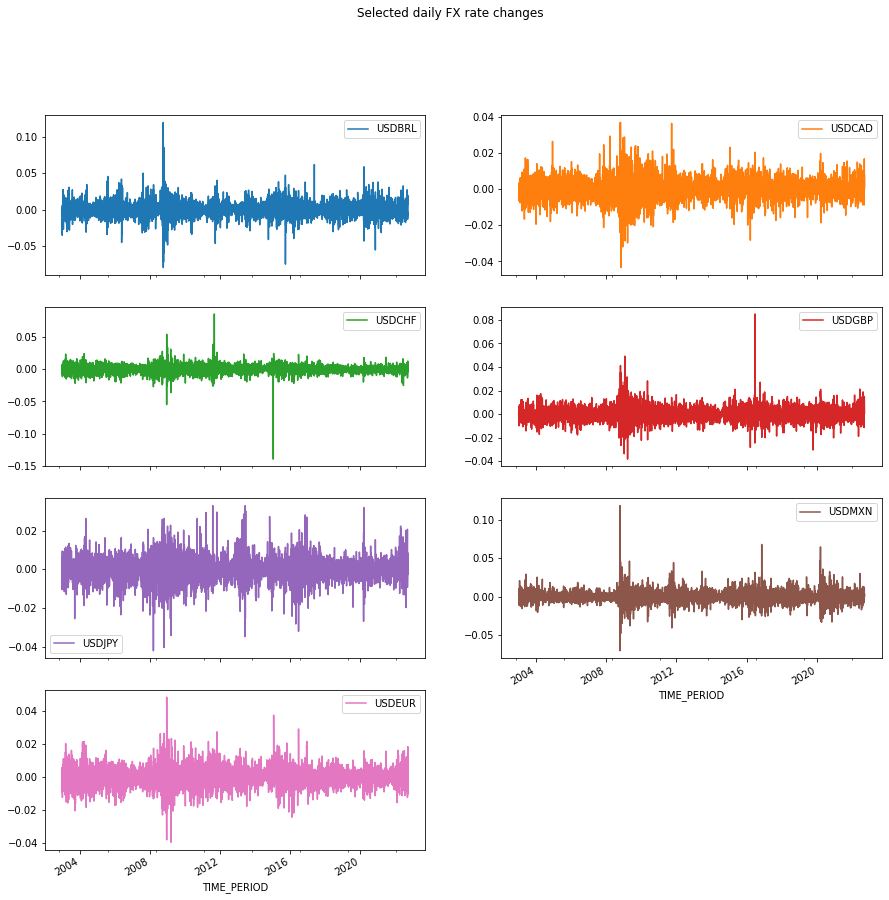

In [ ]:
FX_rate_changes.plot(subplots=True, layout=(4, 2), figsize=(15, 15), sharex=True, title='Selected daily FX rate changes')

## Augmenting the dataset

We will complement the FX rates data with two other datasets:

* daily central bank policy rates from the Bank for International Settlements (BIS) [-@BISstatQR2017], and

* the daily Composite Indicator of Systemic Stress (CISS), created by @hollo2012ciss and updated by the European Central Bank (ECB).

In [ ]:
from gingado.augmentation import AugmentSDMX

In [ ]:
X = AugmentSDMX(sources={'BIS': 'WS_CBPOL_D', 'ECB': 'CISS'}).fit_transform(FX_rate_changes)

Querying data from BIS's dataflow 'WS_CBPOL_D' - Policy rates daily...
Querying data from ECB's dataflow 'CISS' - Composite Indicator of Systemic Stress...


2022-09-24 00:51:08,339 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


:::{.callout-note}

it is acceptable in `gingado` to pass the variable of interest (the "y", or in this case, `FX_rate_changes`) as the `X` argument in `fit_transform`. This is because this series will also be merged with the additional, augmented data and subsequently lagged along with it.

:::

You can see below that the column names for the newly added columns reflect the source (BIS or ECB), the dataflow (separated from the source by a double underline), and then the specific keys to the series, which are specific to each dataflow.

In [ ]:
X.columns

Index(['USDBRL', 'USDCAD', 'USDCHF', 'USDGBP', 'USDJPY', 'USDMXN', 'USDEUR',
       'BIS__WS_CBPOL_D_D__AR', 'BIS__WS_CBPOL_D_D__AU',
       'BIS__WS_CBPOL_D_D__BR', 'BIS__WS_CBPOL_D_D__CA',
       'BIS__WS_CBPOL_D_D__CH', 'BIS__WS_CBPOL_D_D__CL',
       'BIS__WS_CBPOL_D_D__CN', 'BIS__WS_CBPOL_D_D__CO',
       'BIS__WS_CBPOL_D_D__CZ', 'BIS__WS_CBPOL_D_D__DK',
       'BIS__WS_CBPOL_D_D__GB', 'BIS__WS_CBPOL_D_D__HK',
       'BIS__WS_CBPOL_D_D__HR', 'BIS__WS_CBPOL_D_D__HU',
       'BIS__WS_CBPOL_D_D__ID', 'BIS__WS_CBPOL_D_D__IL',
       'BIS__WS_CBPOL_D_D__IN', 'BIS__WS_CBPOL_D_D__IS',
       'BIS__WS_CBPOL_D_D__JP', 'BIS__WS_CBPOL_D_D__KR',
       'BIS__WS_CBPOL_D_D__MK', 'BIS__WS_CBPOL_D_D__MX',
       'BIS__WS_CBPOL_D_D__MY', 'BIS__WS_CBPOL_D_D__NO',
       'BIS__WS_CBPOL_D_D__NZ', 'BIS__WS_CBPOL_D_D__PE',
       'BIS__WS_CBPOL_D_D__PH', 'BIS__WS_CBPOL_D_D__PL',
       'BIS__WS_CBPOL_D_D__RO', 'BIS__WS_CBPOL_D_D__RS',
       'BIS__WS_CBPOL_D_D__RU', 'BIS__WS_CBPOL_D_D__SA',
       'BIS

Before proceeding, we also include a differentiated version of the central bank policy data. It will be sparse, since these changes occur infrequently for most central banks, but it can help the model uncover how FX rate changes respond to central bank policy changes.

In [ ]:
import pandas as pd

In [ ]:
X_diff = X.loc[:, X.columns.str.contains("BIS__WS_CBPOL_D", case=False)].diff()
X_diff.columns = [col + "_diff" for col in X_diff.columns]
X = pd.concat([X, X_diff], axis=1)

This is how the data looks like now. Note that the names of the added columns reflect the source, dataflow and keys, all separated by underlines (the source is separated from the dataflow by two underlines at all cases). For example, the last key is the jurisdiction of the central bank.

We will keep all the newly added variables - even those that are from countries not in the currency list. This is because the model may uncover any relationship of interest between central bank policies from other countries and each particular currency pair.

In [ ]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
USDBRL,5098.0,0.000136,0.010597,-0.080226,-0.005774,-0.000018,0.005402,0.120503
USDCAD,5098.0,-0.000016,0.005844,-0.043367,-0.003222,-0.000138,0.003036,0.036864
USDCHF,5098.0,-0.000050,0.006434,-0.139149,-0.003241,0.000000,0.003257,0.085326
USDGBP,5098.0,0.000085,0.005998,-0.038140,-0.003307,0.000000,0.003241,0.085019
USDJPY,5098.0,0.000054,0.005970,-0.041963,-0.003007,0.000116,0.003183,0.032901
...,...,...,...,...,...,...,...,...
BIS__WS_CBPOL_D_D__TH_diff,5097.0,-0.000196,0.033590,-1.000000,0.000000,0.000000,0.000000,0.500000
BIS__WS_CBPOL_D_D__TR_diff,5097.0,-0.006082,0.252368,-4.250000,0.000000,0.000000,0.000000,8.500000
BIS__WS_CBPOL_D_D__US_diff,5097.0,0.000221,0.038721,-1.000000,0.000000,0.000000,0.000000,0.750000
BIS__WS_CBPOL_D_D__XM_diff,5097.0,-0.000294,0.027431,-0.750000,0.000000,0.000000,0.000000,0.750000


The policy rates for some central banks have less observations than the others, as seen above.

Because some data are missing, we will impute data for the missing dates, by simply propagating the last valid observation, and when that is not possible, replacing the missing information with a "0".

In [ ]:
X.fillna(method='pad', inplace=True)
X.fillna(value=0, inplace=True)

Now is a good time to start the model documentation. For this, we can use the standard model card that already comes with `gingado`.

The goal is to facilitate economists who want to make model documentation a part of their normal workflow.

In [ ]:
from gingado.model_documentation import ModelCard

In [ ]:
model_doc = ModelCard()
model_doc.open_questions()

['model_details__developer',
 'model_details__version',
 'model_details__type',
 'model_details__info',
 'model_details__paper',
 'model_details__citation',
 'model_details__license',
 'model_details__contact',
 'intended_use__primary_uses',
 'intended_use__primary_users',
 'intended_use__out_of_scope',
 'factors__relevant',
 'factors__evaluation',
 'metrics__performance_measures',
 'metrics__thresholds',
 'metrics__variation_approaches',
 'evaluation_data__datasets',
 'evaluation_data__motivation',
 'evaluation_data__preprocessing',
 'training_data__training_data',
 'quant_analyses__unitary',
 'quant_analyses__intersectional',
 'ethical_considerations__sensitive_data',
 'ethical_considerations__human_life',
 'ethical_considerations__mitigations',
 'ethical_considerations__risks_and_harms',
 'ethical_considerations__use_cases',
 'ethical_considerations__additional_information',
 'caveats_recommendations__caveats',
 'caveats_recommendations__recommendations']

As an example, we can add the following information to the model:

In [ ]:
model_doc.fill_info({
    'intended_use': {
        'primary_uses': 'These models are simplified toy models made to illustrate the use of gingado',
        'out_of_scope': 'These models were not constructed for decision-making and as such their use as predictors in real life decisions is strongly discouraged and out of scope.'
    },
    'metrics': {
        'performance_measures': 'Consistent with most papers reviewed by Rossi (2013), these models were evaluated by their root mean squared error.'
    },
    'ethical_considerations': {
        'sensitive_data': 'These models were not trained with sensitive data.',
        'human_life': 'The models do not involve the collection or use of individual-level data, and have no foreseen impact on human life.'
    },
    
})

## Lagging the regressors

This model will not include any contemporaneous variable. Therefore, all regresors must be lagged.

For illustration purposes, we use 5 lags in this exercise.

In [ ]:
from gingado.utils import Lag

In [ ]:
n_lags = 5

X_lagged = Lag(lags=n_lags).fit_transform(X)
X_lagged

y = FX_rate_changes[n_lags:]

Now is a good opportunity to check by how much we have increased our regressor space:

In [ ]:
pd.Series({
    "FX rates only": y.shape[1],
    "... with augmentation_": X.shape[1],
    "... lagged": X_lagged.shape[1]
})

FX rates only               7
... with augmentation_    105
... lagged                525
dtype: int64

## Training the models

Our dataset is now complete. Before using it to train the models, we hold out the most recent data to serve as our testing dataset, so we can compare our models with real out-of-sample information.

We can choose, say, 1st January 2022.

In [ ]:
cutoff = '2020-01-01'

X_train, X_test = X_lagged[:cutoff], X_lagged[cutoff:]
y_train, y_test = y[:cutoff], y[cutoff:]

In [ ]:
model_doc.fill_info({
    'training_data': 
    {'training_data': 
        """
        The training data comprise time series obtained from official sources (BIS and ECB) on:
        * foreign exchange rates
        * central bank policy rates
        * an estimated indicator for systemic stress
        The training and evaluation datasets are the same time series, only different windows in time."""
    }
})

The current status of the documentation is:

In [ ]:
pd.Series(model_doc.show_json())

model_details              {'developer': 'Person or organisation developi...
intended_use               {'primary_uses': 'These models are simplified ...
factors                    {'relevant': 'Relevant factors', 'evaluation':...
metrics                    {'performance_measures': 'Consistent with most...
evaluation_data            {'datasets': 'Datasets', 'motivation': 'Motiva...
training_data              {'training_data': '
        The training data ...
quant_analyses             {'unitary': 'Unitary results', 'intersectional...
ethical_considerations     {'sensitive_data': 'These models were not trai...
caveats_recommendations    {'caveats': 'For example, did the results sugg...
dtype: object

### Creating a random walk benchmark

@rossi2013exchange highlights that few predictors beat the random walk without drift model. This is a good opportunity to showcase how we can use `gingado`'s in-built base class `ggdBenchmark` to build our customised benchmark model, in this case a random walk.

The calculation of the random walk benchmark is very simple. Still, creating a `gingado` benchmark offers some advantages: it is easier to compare alternative models, and the model documentation is done more seamlessly.

A custom benchmark model must implement the following steps:

* sub-class `ggdBenchmark` (or alternatively implement its methods)

* define an `estimator` that is compatible with `scikit-learn`'s API:
    * at the very least, it has a `fit` method that returns `self`

If the user is relying on a custom estimator - like in this case, a random walk estimator to align with the literature - then this custom estimator also has some requirements:

* it should ideally subclass `scikit-learn`'s `BaseEstimator` (mostly for the `get_params` / `set_params` methods)

* three methods are necessary:
    * `fit`, which should at least create an attribute ending in an underline ("_"), so that `gingado` knows it is fitted
    * `predict`
    * `score`

In [ ]:
import numpy as np
from gingado.benchmark import ggdBenchmark
from sklearn.base import BaseEstimator
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
class RandomWalkEstimator(BaseEstimator):
    def __init__(self, scoring='neg_root_mean_squared_error'):
        self.scoring = scoring
    
    def fit(self, X, y=None):
        self.n_samples_ = X.shape[0]
        return self

    def predict(self, X):
        return np.zeros(X.shape[0])

    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import mean_squared_error
        y_pred = self.predict(X)
        return mean_squared_error(y, y_pred, sample_weight=sample_weight, squared=False)

    def forecast(self, forecast_horizon=1):
        self.forecast_horizon = forecast_horizon
        return np.zeros(self.forecast_horizon)

class RandomWalkBenchmark(ggdBenchmark):
    def __init__(
        self, 
        estimator=RandomWalkEstimator(), 
        auto_document=ModelCard,
        cv=TimeSeriesSplit(n_splits=10, test_size=60), 
        ensemble_method=VotingRegressor, 
        verbose_grid=None):
        self.estimator=estimator
        self.auto_document=auto_document
        self.cv=cv
        self.ensemble_method=ensemble_method
        self.verbose_grid=verbose_grid

    def fit(self, X, y=None):
        self.benchmark=self.estimator
        self.benchmark.fit(X, y)
        return self

### Training the candidate models

Now that we have a benchmark, we can create candidate models that will try to beat it.

In this simplified example, we will choose only two: a random forest, an AdaBoost regressor and a Lasso model. Their hyperparameters are not particularly important for the example, but of course they could be fine-tuned as well.

In the language of @rossi2013exchange, the models below are one *"single-equation, lagged fundamental model"* for each currency.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso

In [ ]:
forest = RandomForestRegressor(n_estimators=250, max_features='log2').fit(X_train, y_train['USDBRL'])
adaboost = AdaBoostRegressor(n_estimators=150).fit(X_train, y_train['USDBRL'])
lasso = Lasso(alpha=0.1).fit(X_train, y_train['USDBRL'])

rw = RandomWalkBenchmark().fit(X_train, y_train['USDBRL'])

We can now compare the model results, using the test dataset we held out previously.

Note that we must pass the criterion against which we are comparing the forecasts.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
results = rw.compare_fitted_candidates(
    X_test, y_test['USDBRL'],
    candidates=[forest, adaboost, lasso],
    scoring_func=mean_squared_error)

pd.Series(results)

RandomWalkEstimator()                                           0.000127
RandomForestRegressor(max_features='log2', n_estimators=250)    0.000129
AdaBoostRegressor(n_estimators=150)                             0.000132
Lasso(alpha=0.1)                                                0.000126
dtype: float64

As mentioned above, benchmarks can facilitate the model documentation. In addition to the broader documentation that is already ongoing, each benchmark object create their own where they store model information. We can use that for the broader documentation.

In our case, the only parameter we created above during fit is the number of samples: not a particularly informative variable but it was included just for illustration purposes. In any case, the parameter appears in the "model_details" section, item "info", of the benchmark's `rw` documentation. Similarly, the parameters of more fully-fledged estimators also appear in that section.

In [ ]:
rw.document()

rw.model_documentation.show_json()['model_details']['info']

{'n_samples_': 4394}

In [ ]:
model_doc.fill_info({
    'model_details': {'info': rw.model_documentation.show_json()['model_details']['info']}
})

In [ ]:
model_doc.show_json()

{'model_details': {'developer': 'Person or organisation developing the model',
  'datetime': '2022-09-24 00:51:37 ',
  'version': 'Model version',
  'type': 'Model type',
  'info': {'n_samples_': 4394},
  'paper': 'Paper or other resource for more information',
  'citation': 'Citation details',
  'license': 'License',
  'contact': 'Where to send questions or comments about the model'},
 'intended_use': {'primary_uses': 'These models are simplified toy models made to illustrate the use of gingado',
  'primary_users': 'Primary intended users',
  'out_of_scope': 'These models were not constructed for decision-making and as such their use as predictors in real life decisions is strongly discouraged and out of scope.'},
 'factors': {'relevant': 'Relevant factors',
  'evaluation': 'Evaluation factors'},
 'metrics': {'performance_measures': 'Consistent with most papers reviewed by Rossi (2013), these models were evaluated by their root mean squared error.',
  'thresholds': 'Decision threshold

We can save the documentation to disk in JSON format with `model_doc.save_json()`, or parse it to create other documents (eg, a PDF file) using third-party libraries.

## References

::: {#refs}
:::

In [ ]:
#| echo: false
import nbdev; nbdev.nbdev_export()